# Context

This notebook aims at iterating over different classification machine learning model to generate tags for StackOverflow questions. the iterations range from unsupervised to supervised approaches with multiple text verctorizing techniques.

# Data Env

In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [2]:
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

'''Sklearn'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import set_config
set_config(display='diagram')

'''gensim'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display, HTML

In [3]:
#read cleaned data
from ast import literal_eval
data = pd.read_csv("../Data/StackOverflow_questions_2009_2020_cleaned.csv",
                   sep=";", index_col=0, 
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})
data.head(5)

,Title,Body,Score,Tags
Id,,,,
4,[decimal],"[variable, trans, variable, opacity, app, erro...",792,[c#]
13,"[user, timezone]","[way, web, server, user, timezone, web, page, ...",698,[html]
19,"[way, value]","[way, value, challenge, way, constant, number,...",350,"[performance, algorithm]"
123,"[java, lib, app, csv, xml, file]","[application, library, java, data, file, file,...",120,[java]
888,"[php, script]","[php, script, debugging, error, reporting, bre...",403,"[php, eclipse]"


In [4]:
data.shape

(76060, 4)

# Preproc 

In [5]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(5)

Id
4      [decimal, variable, trans, variable, opacity, ...
13     [user, timezone, way, web, server, user, timez...
19     [way, value, way, value, challenge, way, const...
123    [java, lib, app, csv, xml, file, application, ...
888    [php, script, php, script, debugging, error, r...
Name: Full_doc, dtype: object

In [6]:
#Define X & y
X = data["Full_doc"]
y = data["Tags"]

# Initialize the "CountVectorizer" for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.6,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X: {}".format(X_tfidf.shape))

# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of X: (76060, 636)
Shape of y: (76060, 50)


In [7]:
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242, 636)
X_test shape : (22818, 636)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


# Unsurpervised Modelling 

In [8]:
# Create dic (bag of words)
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]]


In [9]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('app', 1),
  ('decimal', 1),
  ('error', 1),
  ('opacity', 1),
  ('trans', 1),
  ('type', 1),
  ('variable', 2)]]

In [10]:
# Build LDA model
lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.011318403041642

Coherence Score:  0.42858266136393464


In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



## LDA optimization 

In [12]:
import time
# Iteration
# best number of topics?
coherence_test = []
for k in np.arange(1,90,9):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 10
Fitting LDA for K = 19
Fitting LDA for K = 28
Fitting LDA for K = 37
Fitting LDA for K = 46
Fitting LDA for K = 55
Fitting LDA for K = 64
Fitting LDA for K = 73
Fitting LDA for K = 82


In [13]:
# coherence scores into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,10.268000
1,10,0.433729,19.699053
2,19,0.422732,22.966839
3,28,0.412987,23.343999
4,37,0.416835,24.673268
5,46,0.411397,27.463385
6,55,0.408546,34.936328
7,64,0.408479,42.601698
8,73,0.399096,44.370674
9,82,0.404654,750.856692


In [14]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 10


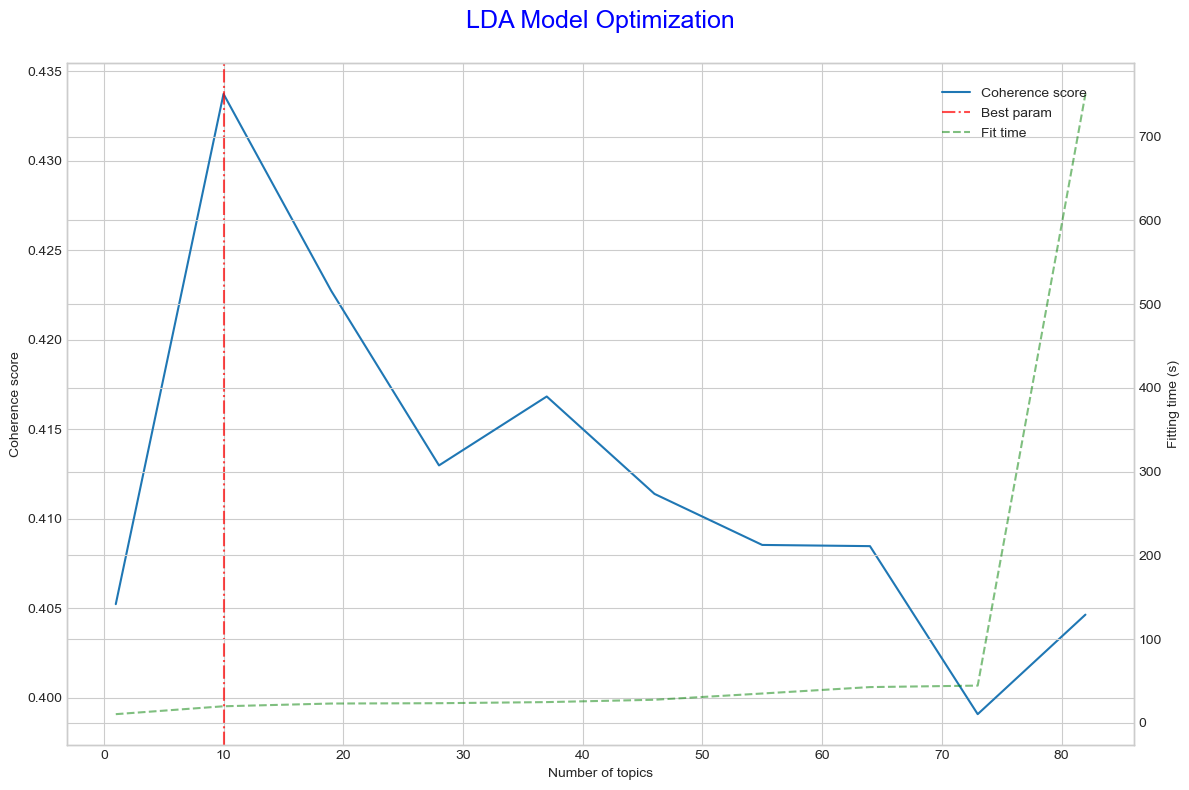

In [15]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Reducing the range of number of topics 

In [16]:
coherence_test = []
for k in np.arange(1,20,2):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model_ = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda_ = CoherenceModel(model=lda_model_,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda_.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 3
Fitting LDA for K = 5
Fitting LDA for K = 7
Fitting LDA for K = 9
Fitting LDA for K = 11
Fitting LDA for K = 13
Fitting LDA for K = 15
Fitting LDA for K = 17
Fitting LDA for K = 19


In [17]:
# coherence scores with the new range into a dataframe
coherence_scores = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_scores

,k,coherence,time
0,1,0.405238,10.040653
1,3,0.402211,18.025199
2,5,0.408836,18.220342
3,7,0.425425,19.034021
4,9,0.428954,19.225685
5,11,0.435295,19.680238
6,13,0.431968,20.179509
7,15,0.426824,20.706876
8,17,0.425162,20.907431
9,19,0.422732,22.378003


In [18]:
# Select best number of topics
best_topics_k = coherence_scores\
                    .loc[coherence_scores.coherence.argmax(),"k"]
print('Optimal number of topics:', best_topics_k)

Optimal number of topics: 11


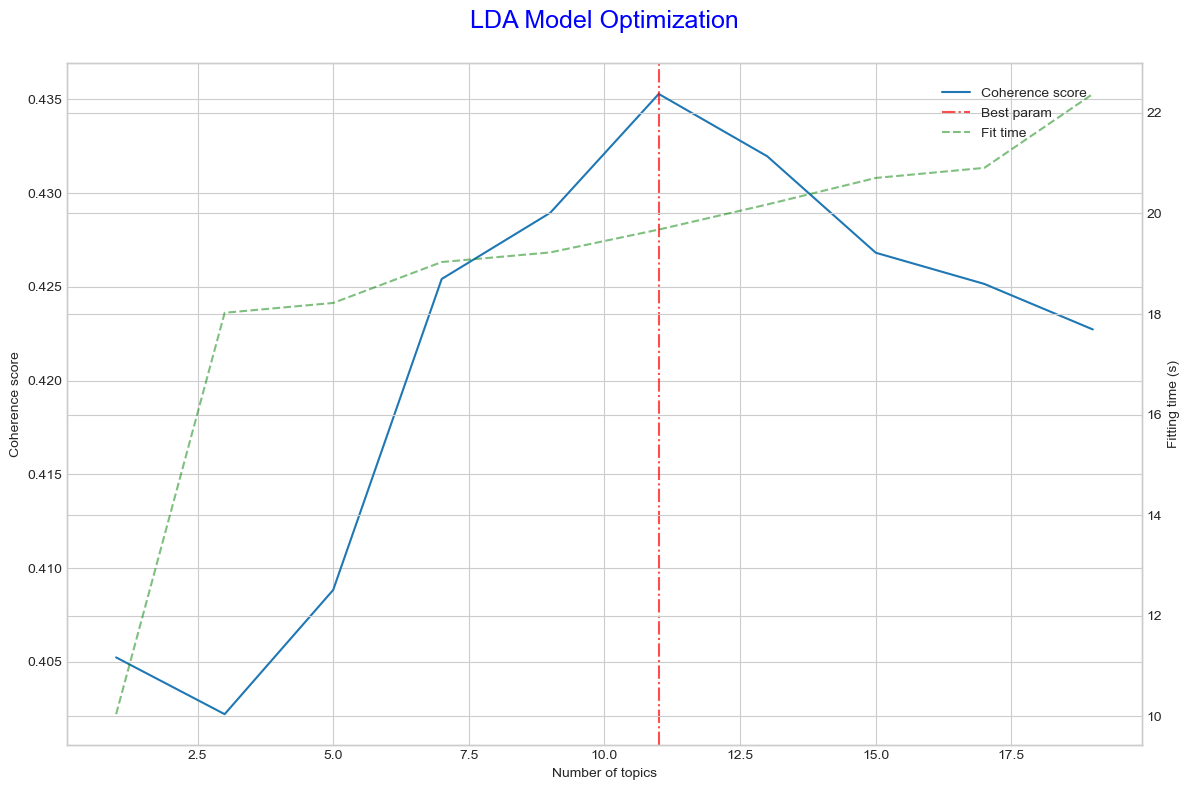

In [19]:
#Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_scores["k"]
y1 = coherence_scores["coherence"]
y2 = coherence_scores["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_topics_k, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of topics")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("LDA Model Optimization\n",
          color="blue", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

## Initialize with best topics number

In [20]:
#re-initialize with best topics number 
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_topics_k,
                                  random_state=42,
                                  per_word_topics=True,
                                  workers=4)
gensimvis.prepare(best_lda_model, corpus, id2word)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.078256  0.091495       1        1  13.802069
8      0.116015 -0.047622       2        1  12.166710
9      0.044632 -0.078913       3        1  12.077748
6      0.003891  0.091495       4        1  10.954789
0     -0.024701  0.051807       5        1   9.266697
1     -0.152971 -0.104615       6        1   7.697293
10     0.042432 -0.009023       7        1   7.484180
4      0.069359  0.029183       8        1   7.256599
3     -0.005954 -0.034531       9        1   6.760649
7     -0.021499  0.027836      10        1   6.359611
2      0.007053 -0.017111      11        1   6.173656, topic_info=         Term          Freq         Total Category  logprob  loglift
48       file  35312.000000  35312.000000  Default  30.0000  30.0000
85      class  22850.000000  22850.000000  Default  29.0000  29.0000
11     string  14803.000000  14803.000000  Default  28.0000  28.0000
307     image  10328.000000  10328.000000  Default  27.0000  27.0000
117     table  10697.000000  10697.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
47       data   1034.208389  20808.820917  Topic11  -5.0298  -0.2169
762   request    753.910860   6770.097305  Topic11  -5.3459   0.5899
223     issue    830.278002  12334.819118  Topic11  -5.2494   0.0865
137  function    904.879212  26899.524642  Topic11  -5.1634  -0.6072
13       user    757.205615  14992.634740  Topic11  -5.3415  -0.2008

[1026 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
7751      1  0.023064  acceleration
7751      2  0.107632  acceleration
7751      4  0.023064  acceleration
7751      5  0.007688  acceleration
7751      7  0.015376  acceleration
...     ...       ...           ...
3903      7  0.564031          zone
3903      8  0.018313          zone
3903      9  0.146501          zone
3903     10  0.080576          zone
3903     11  0.036625          zone

[4590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 9, 10, 7, 1, 2, 11, 5, 4, 8, 3])

In [21]:
from imp import reload

In [22]:
#  Document X topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(corpus,
                                                minimum_probability=0))

for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_binarized.shape)
print('document/topic : ', doc_topic.shape)
doc_topic.head(3)

document/tag :  (76060, 50)
document/topic :  (76060, 11)


,0,1,2,3,4,5,6,7,8,9,10
0,0.010144,0.010145,0.010142,0.010142,0.010143,0.755670,0.010143,0.010145,0.153041,0.010143,0.010143
1,0.006994,0.006994,0.156882,0.006994,0.006994,0.006994,0.006994,0.006994,0.359809,0.006994,0.427356
2,0.001977,0.001977,0.001977,0.001977,0.001977,0.484419,0.001977,0.001977,0.001977,0.001977,0.497784


In [23]:
y_binarized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [24]:
#topic X tags matrix
# Matricial multiplication with DocumentXTopics transpose
topic_tag = np.matmul(doc_topic.T, y_binarized) # rows represent topics
print(topic_tag.shape) # columns represent the disctribution of the associated tags
topic_tag

(11, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,361.905339,243.854405,140.485453,10.320877,93.160330,44.419177,9.656629,22.198371,703.567240,886.169570,...,36.497995,20.347784,11.584929,369.792106,195.370715,80.991758,29.916435,19.433170,73.205291,20.811848
1,92.754989,698.989344,535.573570,138.135838,51.606970,34.798129,50.357952,28.444907,289.151156,402.532767,...,43.697997,34.264229,6.832901,76.581458,40.522883,55.436560,124.303899,14.566582,26.352315,60.717281
2,246.847197,227.193795,171.104291,58.118494,61.627035,85.532417,41.214318,106.931436,181.516396,710.642981,...,61.766079,48.866036,39.880499,55.627191,31.557224,512.652908,25.562430,23.112938,47.717369,12.602014
3,177.726729,239.505314,356.341775,95.307172,26.487610,100.334679,61.166548,10.104395,113.268010,484.461936,...,31.053924,39.780280,15.109631,85.598311,43.034345,19.911176,38.132822,17.052947,47.481745,15.316571
4,327.470305,80.591336,120.871565,24.720928,26.183545,139.546604,126.569288,13.894648,98.813339,936.326053,...,42.175740,84.858495,163.373185,819.568658,533.965625,24.290601,19.624823,26.458434,51.369867,17.314701
5,337.235038,960.855539,124.416775,104.001642,928.001139,37.035893,32.395069,42.620642,1503.149886,1256.720239,...,110.677741,26.017095,8.323085,90.720252,50.408237,290.139077,182.636983,35.196588,30.960287,27.416343
6,556.414167,44.817309,277.280293,58.052883,66.311865,68.949974,53.782442,7.316057,377.731271,1650.358950,...,52.980385,30.891205,206.238239,24.219929,14.094066,71.530785,99.102673,111.503181,26.998874,55.874686
7,191.447325,99.731328,550.273503,27.289203,37.064794,53.425588,84.040674,15.382977,434.879546,641.077831,...,27.333806,30.361697,18.860648,18.523673,9.531297,63.463651,65.221906,22.691067,63.773669,45.221145
8,356.585778,20.944545,2150.013694,131.377995,14.739568,291.328333,164.617024,37.932406,174.729824,923.659524,...,81.696427,151.879521,74.012421,76.591252,127.564125,16.929958,127.908206,49.146367,158.813606,353.857650
9,361.921609,40.903761,936.096792,109.706533,32.763475,219.766664,163.646919,252.623116,316.737345,1080.426067,...,64.250126,82.338268,60.333955,35.108679,32.155964,37.278216,50.768287,318.568409,447.927522,84.129340


In [25]:
# dataframe of predictions
y_results = pd.DataFrame(y)
y_results["rep_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

In [26]:
y_results

,Tags,rep_topic,nb_tags
Id,,,
4,[c#],5,1
13,[html],10,1
19,"[performance, algorithm]",10,2
123,[java],9,1
888,"[php, eclipse]",2,2
...,...,...,...
36371706,"[arrays, performance]",5,2
36371748,"[java, spring]",9,2
36372274,[git],10,1


In [ ]:
#groupby y binarized index
df_y_2 = pd.DataFrame(y_binarized)
df_dict = dict(list(df_y_2.groupby(df_y_2.index)))

#intiate a list of tags numbers 
num_tags = []
for key, value in df_dict.items():
    check = value.columns[(value == 1).any()]
    num_tags.append(check.to_list())
print(num_tags)

In [28]:
y_binarized

In [29]:
y_results["y_true"] = num_tags
y_results.head(3)

,Tags,rep_topic,nb_tags,y_true
Id,,,,
4,[c#],5,1,[9]
13,[html],10,1,[20]
19,"[performance, algorithm]",10,2,"[1, 35]"


In [30]:
# Selecting predicted tags from Topics X Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.rep_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results.head(3)

/var/folders/_5/rhjg3s115y30bg6bd3kvpsj00000gn/T/ipykernel_35067/1552659229.py:6: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



,Tags,rep_topic,nb_tags,y_true,y_pred
Id,,,,,
4,[c#],5,1,[9],[10]
13,[html],10,1,[20],[23]
19,"[performance, algorithm]",10,2,"[1, 35]","[23, 24]"


## LDA Model evaluation

In [31]:
metrics

<module 'sklearn.metrics' from '/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/__init__.py'>

In [32]:
def metrics_scores(model, df, y_true, y_pred):
    if(df is not None):
        scores_df = df
    else:
        scores_df = pd.DataFrame(index=["Accuracy", "F1",
                                         "Recall",
                                         "Precision"],
                                          columns=[model])
    #intiate scores' list
    scores = []
    #append scores
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    scores_df[model] = scores
    
    return scores_df

In [33]:
# Create matrix for predicted and true tags y
lda_y_pred = np.zeros(y_binarized.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_binarized.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [34]:
#create df of lds metrics chosen above
df_metrics = metrics_scores("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,LDA
Accuracy,0.136221
F1,0.287827
Recall,0.225498
Precision,0.161093


**LDA non supervised approach is not adapted seen the scores results.**

# Supervised Approach 

## Logistic Regression

### Logit Grid search

In [35]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

#Grid search best params
multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [36]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [37]:
logit_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,163.522700,5.691324,0.189659,0.025332,100,False,l1,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.576148,...,0.574785,0.002231,4,0.642562,0.642578,0.643658,0.647786,0.644818,0.644281,0.001940
1,49.838223,3.396435,0.211691,0.027267,100,False,l2,liblinear,"{'estimator__C': 100, 'estimator__dual': False...",0.580745,...,0.580646,0.001777,2,0.634849,0.634559,0.635708,0.639159,0.636971,0.636249,0.001679
2,80.184042,0.774195,0.221995,0.048177,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582465,...,0.581801,0.001465,1,0.629983,0.629756,0.630646,0.633507,0.632234,0.631225,0.001432
3,27.922045,0.673440,0.251279,0.060857,10,False,l2,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.578405,...,0.577189,0.001247,3,0.615259,0.614406,0.615599,0.618281,0.616364,0.615982,0.001310
4,31.026724,0.598755,0.208276,0.017857,1.0,False,l1,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.569667,...,0.567434,0.001595,5,0.584657,0.583765,0.584116,0.587537,0.584560,0.584927,0.001344
5,16.364543,0.142340,0.199532,0.008183,1.0,False,l2,liblinear,"{'estimator__C': 1.0, 'estimator__dual': False...",0.540823,...,0.539112,0.002224,6,0.557612,0.556724,0.557880,0.559746,0.558826,0.558158,0.001039
6,11.582354,0.244609,0.174258,0.018549,0.1,False,l1,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.487127,...,0.484473,0.003460,7,0.486561,0.485552,0.488044,0.488994,0.489560,0.487742,0.001494
7,9.292122,1.094167,0.088467,0.028250,0.1,False,l2,liblinear,"{'estimator__C': 0.1, 'estimator__dual': False...",0.356205,...,0.351351,0.003655,8,0.354953,0.356731,0.358757,0.358854,0.358088,0.357477,0.001472


In [38]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,80.184042,0.774195,0.221995,0.048177,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.582465,...,0.581801,0.001465,1,0.629983,0.629756,0.630646,0.633507,0.632234,0.631225,0.001432


###  Logit Predictions

In [39]:
# Predict
y_test_predicted_labels = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('html', 'javascript'), ('google-chrome', 'javascript'), ('android',), ('android',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [40]:
#Evaluation
df_metrics_logit = metrics_scores("Logit", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels)
df_metrics_logit

,LDA,Logit
Accuracy,0.136221,0.341835
F1,0.287827,0.616689
Recall,0.225498,0.487326
Precision,0.161093,0.744566


## Random Forest

### Grid Search

In [41]:
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on sampled data to reduce fitting time
multi_rfc_cv.fit(X_train[0:5000], y_train[0:5000])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [42]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


In [43]:
#formatting for the arguments of the Model 
rfc_best_params_arg = {}
for k, v in rfc_best_params.items():
    rfc_best_params_arg[k.replace("estimator__","")] = v

In [44]:
# Refit RandomForestClassifier with best_params on full data
rfc_best_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_arg))
rfc_best_model.fit(X_train, y_train)

[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.715, test=0.532) total time=  21.3s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10;, score=(train=0.640, test=0.515) total time=  20.4s
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.809, test=0.559) total time=  35.6s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.814, test=0.535) total time=  36.4s
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=0.998, test=0.329) total time=  46.1s
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.660, test=0.526) total time=  20.6s
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=5, e

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=25,
                                                     min_samples_leaf=5))

### Predict

In [45]:
# Predict
y_test_predicted_labels_rfc = rfc_best_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('eclipse', 'java'), ('html', 'javascript'), ('google-chrome', 'javascript', 'jquery'), ('android',), ('android', 'ios', 'iphone', 'objective-c')]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [46]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc)
df_metrics_rfc

,LDA,Logit,RandomForest
Accuracy,0.136221,0.341835,0.226532
F1,0.287827,0.616689,0.572147
Recall,0.225498,0.487326,0.733300
Precision,0.161093,0.744566,0.529513


## Unpredicted tags

Giving that Logistic regression and Random Forest models perform quite on a similar steak of evaluation, they seem coherent with the data. to be able to tell them apart, we shall see **the number of rows where tags weren't predicted**: 

In [47]:
#tags per row for y_pred logit
Tags_row_logit = y_test_predicted_labels.sum(axis=1)
null_rate_logit = round(((Tags_row_logit.size - np.count_nonzero(Tags_row_logit))
                      /Tags_row_logit.size)*100,2)

#tags per row for y_pred rfc
Tags_row_rfc = y_test_predicted_labels_rfc.sum(axis=1)
null_rate_rfc = round(((Tags_row_rfc.size - np.count_nonzero(Tags_row_rfc))
                       /Tags_row_rfc.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for each model")
print("-" * 50)
print("Logistic Regression: {}%".format(null_rate_logit))
print("Random Forest: {}%".format(null_rate_rfc))

--------------------------------------------------
Percentage of non tagged question for each model
--------------------------------------------------
Logistic Regression: 28.44%
Random Forest: 5.04%


Random Forest model seems more adequate to this multi classification task.

# Neural networks

In [48]:
# NN dependencies 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim
from tensorflow.keras import Sequential, layers
from gensim.models import Word2Vec

In [49]:
# new holdout
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242,)
X_test shape : (22818,)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


In [50]:
X_train

Id
24407931    [java, lambda, expression, iteration, folk, ex...
15140370    [localdb, instance, name, sql, script, sql, se...
20148       [myisam, innodb, project, lot, database, inser...
19145332    [nltk, counting, frequency, bigram, python, nl...
34307379    [table, element, function, table, code, line, ...
                                  ...                        
4937263     [object, networking, number, system, idea, net...
28761365    [promise, story, promise, way, promise, error,...
8167754     [postgres, architecture, app, instance, nginx,...
11165200    [list, view, method, child, publication, item,...
32805916    [compute, jaccard, matrix, matrix, sparsecsr_m...
Name: Full_doc, Length: 53242, dtype: object

## WOR2VEC Embedding

In [51]:
word2vec = gensim.models.Word2Vec(sentences=X_train,
                                  vector_size=300,
                                  min_count=1,
                                  window=10)

In [52]:
#embedding functions 
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

def embedding(word2vec, sentences):
    '''function that, given a list of sentence (each sentence being a list of words/strings),
    returns a list of embedded sentences (each sentence is a matrix).'''
    
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed
   

In [53]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=50)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=50)

In [54]:
#assertions
assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

In [55]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [56]:
def init_model():
    model = Sequential()
    #model.add(layers.Masking())
    model.add(layers.LSTM(300, activation='tanh'))
    model.add(layers.Dense(300, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(y_train.shape[1], activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_m, recall_m, precision_m])
    
    return model

model = init_model()

In [57]:
X_train_pad

array([[[ 3.0121115e-01,  1.4844307e+00,  7.0048994e-01, ...,
         -1.5889770e+00,  1.5111206e+00, -8.3939564e-01],
        [ 2.1745202e-01,  5.9274912e-01, -4.7956201e-01, ...,
         -1.5536839e-01, -4.5896974e-01,  2.6159337e-01],
        [ 1.4742864e+00,  5.7639444e-01,  7.7730566e-02, ...,
         -1.5034460e+00,  1.1596846e-01, -1.6719715e-01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[-1.4006825e-01,  7.0248209e-02,  7.5919474e-03, ...,
          2.4628092e-02,  8.3700968e-03, -1.2096840e-01],
        [-1.4265271e+00, -1.4470346e+00,  3.1126788e-01, ...,
         -9.6198931e-02,  2.4067068e-01, -1.4111983e+00],
        [-2.7395207e-01, 

In [58]:
X_train_pad.shape

(53242, 50, 300)

In [59]:
y_train.shape

(53242, 50)

In [62]:
model.build(y_train.shape[0])

In [63]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                7550      
                                                                 
Total params: 864,200
Trainable params: 864,200
Non-trai

In [61]:
# 
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train,
                      epochs=10,
                      batch_size=32,
                      verbose=1,
                      validation_data=(X_test_pad, y_test),
                      callbacks= [es]
                     )

Epoch 1/10


2023-03-16 01:02:30.642490: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1664/1664 [==============================] - 162s 95ms/step - loss: 0.0917 - accuracy: 0.3686 - f1_m: 0.3124 - recall_m: 0.2285 - precision_m: 0.5482 - val_loss: 0.0630 - val_accuracy: 0.5282 - val_f1_m: 0.5412 - val_recall_m: 0.4220 - val_precision_m: 0.7656
Epoch 2/10
1664/1664 [==============================] - 157s 95ms/step - loss: 0.0602 - accuracy: 0.5564 - f1_m: 0.5755 - recall_m: 0.4656 - precision_m: 0.7632 - val_loss: 0.0557 - val_accuracy: 0.5686 - val_f1_m: 0.6043 - val_recall_m: 0.4960 - val_precision_m: 0.7809
Epoch 3/10
1664/1664 [==============================] - 185s 111ms/step - loss: 0.0546 - accuracy: 0.5842 - f1_m: 0.6196 - recall_m: 0.5178 - precision_m: 0.7789 - val_loss: 0.0535 - val_accuracy: 0.5839 - val_f1_m: 0.6317 - val_recall_m: 0.5345 - val_precision_m: 0.7794
Epoch 4/10
1664/1664 [==============================] - 661s 397ms/step - loss: 0.0510 - accuracy: 0.6029 - f1_m: 0.6436 - recall_m: 0.5474 - precision_m: 0.7876 - val_loss: 0.0528 - val_accuracy: 

In [64]:
#evaluate on test set 
scores = model.evaluate(X_test_pad, y_test)
scores

714/714 [==============================] - 23s 32ms/step - loss: 0.0690 - accuracy: 0.4815 - f1_m: 0.5201 - recall_m: 0.4010 - precision_m: 0.7512


[0.0689677819609642,
 0.4815058410167694,
 0.5200661420822144,
 0.40104150772094727,
 0.7511604428291321]

In [65]:
df_metrics_rfc

,LDA,Logit,RandomForest
Accuracy,0.136221,0.341835,0.226532
F1,0.287827,0.616689,0.572147
Recall,0.225498,0.487326,0.733300
Precision,0.161093,0.744566,0.529513


In [66]:
df_metrics_rfc["Keras_NN_w2v"] = [scores[i] for i in [1,2,3,4]]
df_metrics_rfc

,LDA,Logit,RandomForest,Keras_NN_w2v
Accuracy,0.136221,0.341835,0.226532,0.481506
F1,0.287827,0.616689,0.572147,0.520066
Recall,0.225498,0.487326,0.733300,0.401042
Precision,0.161093,0.744566,0.529513,0.751160


In [67]:
df_metrics_rfc.to_excel("df_metrics_scores.xlsx")

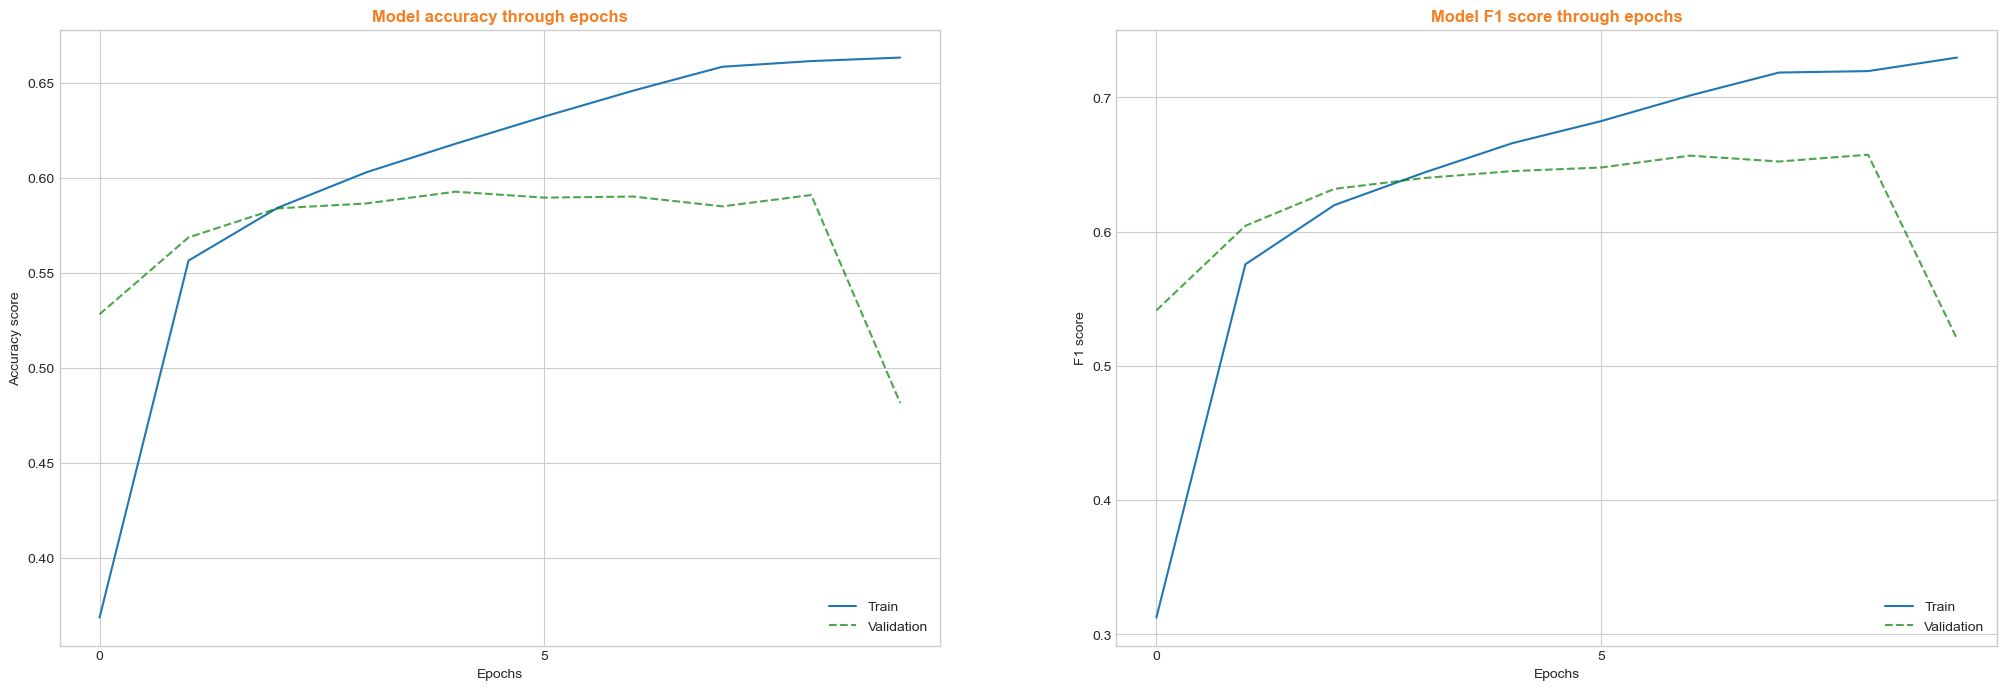

In [68]:
#visualize model accuracy and F1 score
train_accuracy = history.history.get('accuracy', [])
train_f1 = history.history.get('f1_m', [])
val_accuracy = history.history.get('val_accuracy', [])
val_f1 = history.history.get('val_f1_m', [])

fig, axes = plt.subplots(1, 2, figsize=(25, 8))
axes[0].plot(np.arange(0,10,1),
             train_accuracy,
             label="Train")
axes[0].plot(np.arange(0,10,1),
             val_accuracy,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[0].set_xticks(np.arange(0,10,5))
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy score")
axes[0].set_title('Model accuracy through epochs',
                  color='#f48023', fontweight='bold')
axes[0].legend(loc=4)

axes[1].plot(np.arange(0,10,1),
             train_f1, label="Train")
axes[1].plot(np.arange(0,10,1),
             val_f1,
             linestyle='--', color='g', alpha=.7,
             label="Validation")
axes[1].set_xticks(np.arange(0,10,5))
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1 score")
axes[1].set_title('Model F1 score through epochs',
                  color='#f48023', fontweight='bold')
axes[1].legend(loc=4)

plt.show()

In [69]:
# predicitions

# Make prediction with Keras Model using W2V embedding 
y_test_predicted_labels_w2v = model.predict(X_test_pad)
y_test_predicted_labels_w2v  = np.where(y_test_predicted_labels_w2v  >= 0.5, 1, 0)

714/714 [==============================] - 25s 35ms/step


In [70]:
# Inverse transform
y_test_pred_inversed_w2v = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_w2v)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_w2v[0:5])
print("True:", y_test_inversed[0:5])

Tags_per_row_keras = y_test_predicted_labels_w2v.sum(axis=1)
null_rate_keras = round(((Tags_per_row_keras.size - np.count_nonzero(Tags_per_row_keras))
                       /Tags_per_row_keras.size)*100,2)
print("\n")
print("-"*50)
print("Percentage of non tagged question for Keras model using w2v embedding")
print("-" * 50)
print("Keras model: {}%".format(null_rate_keras))

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), (), ('google-chrome',), ('android',), ('ios',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


--------------------------------------------------
Percentage of non tagged question for Keras model using w2v embedding
--------------------------------------------------
Keras model: 32.76%


## BERT Embedding

In [71]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.0
2.9.0
Num GPUs Available:  1
False


In [72]:
# Bert
from transformers import *
import time

<frozen importlib._bootstrap>:283: DeprecationWarning:

the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning:

Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/generation_tf_utils.py:24: FutureWarning:

Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/transformers/models/deit/image_processing_deit.py:86: DeprecationWarning:

BICUBIC is deprecated and will be removed in Pillow 10 (2023

In [73]:
# untokenize data to take into account Bert implied Tokenization
def untokenize(data):
    for tokens in data:
        yield ' '.join(tokens)
        
X_untokenized = list(untokenize(X))
X_untokenized

['decimal variable trans variable opacity app error type',
 'user timezone way web server user timezone web page header part string',
 'way value way value challenge way constant number program test way inline assembly version theory option baseline version test in version gcc auto constant version testing program inline assembly stuff system build script configuration testing compiler flag bit bit optimization order test version top time',
 'java lib app csv xml file application library java data file file tag row column heading',
 'php script php script debugging error reporting breakpoint phpeclipse term way phpstorm ide',
 'diversion point imprecision part mathematician point implementation dispute language implementation method result',
 'xampp apache file htdocs folder xampp file directory instance file xampp file default configuration way apache file apache access content project directory project directory edit apache question title',
 'class performance benefit lot optimizatio

In [74]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model_bert = TFAutoModel.from_pretrained(model_type)

loading configuration file config.json from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db42

In [75]:
# sentences processing function 
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot


In [76]:
# features creation function
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [77]:
len(X_untokenized[:3000])

3000

In [78]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model_bert, model_type, X_untokenized[:10000], 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/oumniasadaouni/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891c

1/1 [==============================] - 1s 884ms/step


1/1 [==============================] - 1s 594ms/step


1/1 [==============================] - 1s 722ms/step


1/1 [==============================] - 1s 816ms/step
temps traitement :  1297.0


In [79]:
features_bert

array([[-0.1504677 , -0.18781541,  0.1090909 , ..., -0.15699613,
        -0.28794414,  0.38851807],
       [ 0.0108176 , -0.2131879 ,  0.4182721 , ..., -0.30971128,
        -0.0398398 ,  0.34313178],
       [ 0.18069465, -0.11888204,  0.28004625, ..., -0.44956726,
        -0.23204418, -0.0152758 ],
       ...,
       [-0.10653795, -0.22928075,  0.3347232 , ..., -0.21671864,
        -0.30861074,  0.05208834],
       [ 0.08604047,  0.10514589,  0.0344813 , ..., -0.36397436,
         0.12923919,  0.35650393],
       [ 0.19070767,  0.5087419 ,  0.3495859 , ..., -0.49449176,
        -0.2595355 ,  0.22471559]], dtype=float32)

In [ ]:
features_bert_1, last_hidden_states_tot_1 = feature_BERT_fct(model_bert, model_type, X_untokenized[10000:20000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_2, last_hidden_states_tot_2 = feature_BERT_fct(model_bert, model_type, X_untokenized[20000:30000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_3, last_hidden_states_tot_3 = feature_BERT_fct(model_bert, model_type, X_untokenized[30000:40000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_4, last_hidden_states_tot_4 = feature_BERT_fct(model_bert, model_type, X_untokenized[40000:50000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_5, last_hidden_states_tot_5 = feature_BERT_fct(model_bert, model_type, X_untokenized[50000:60000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_6, last_hidden_states_tot_6 = feature_BERT_fct(model_bert, model_type, X_untokenized[50000:60000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_7, last_hidden_states_tot_7 = feature_BERT_fct(model_bert, model_type, X_untokenized[60000:70000], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
features_bert_8, last_hidden_states_tot_8 = feature_BERT_fct(model_bert, model_type, X_untokenized[70000:], 
                                                         max_length, batch_size, mode='HF')

In [ ]:
#vstack
#holdout
#NN 

In [81]:
# we'll restrain to a 10K sample for fitting time purposes
y_binarized_samp = y_binarized[:10000]

In [82]:
# new holdout with bert embedded questions 
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(features_bert, y_binarized_samp,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (7000, 768)
X_test shape : (3000, 768)
y_train shape : (7000, 50)
y_test shape : (3000, 50)


In [88]:
#fitting a random forest for this instance 
#Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

bert_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=5,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on sampled data to reduce fitting time
bert_rfc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENI

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is p

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 3 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.701, test=0.388) total time= 7.4min
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10;, score=(train=0.688, test=0.407) total time= 7.1min
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=1;, score=(train=0.998, test=0.100) total time= 9.1min
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=10;, score=(train=0.976, test=0.264) total time= 8.9min
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=1.000, test=0.085) total time= 9.7min
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=5;, score=(train=0.690, test=0.401) total time= 7.4min
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=5, 

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: Undefin

[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.699, test=0.395) total time= 7.5min
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=1;, score=(train=0.998, test=0.113) total time= 9.1min
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=5;, score=(train=0.995, test=0.169) total time= 9.4min
[CV 2/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=1;, score=(train=1.000, test=0.068) total time= 9.6min
[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=5;, score=(train=0.995, test=0.195) total time= 8.9min


/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning:

Label not 3 is present in all training examples.



[CV 5/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=1;, score=(train=0.696, test=0.397) total time= 7.4min
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=5, estimator__min_samples_leaf=10;, score=(train=0.689, test=0.385) total time= 7.0min
[CV 3/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=1;, score=(train=0.998, test=0.121) total time= 9.2min
[CV 4/5] END estimator__class_weight=balanced, estimator__max_depth=25, estimator__min_samples_leaf=10;, score=(train=0.975, test=0.251) total time= 8.9min
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=5;, score=(train=0.995, test=0.158) total time= 9.3min
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=50, estimator__min_samples_leaf=10;, score=(train=0.977, test=0.236) total time= 7.1min
[CV 1/5] END estimator__class_weight=balanced, estimator__max_depth=5

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [89]:
bert_rfc_cv_results = pd.DataFrame.from_dict(bert_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
bert_rfc_best_params = bert_rfc_cv.best_params_
print(bert_rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 5, 'estimator__min_samples_leaf': 10}


In [96]:
#formatting for the arguments of the Model 
bert_rfc_best_params_arg = {}
for k, v in bert_rfc_best_params.items():
    bert_rfc_best_params_arg[k.replace("estimator__","")] = v

In [97]:
# Refit RandomForestClassifier with best_params on full data
bert_rfc_best_model = OneVsRestClassifier(RandomForestClassifier(**bert_rfc_best_params_arg))
bert_rfc_best_model.fit(X_train, y_train)

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning:

Label not 3 is present in all training examples.



OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     min_samples_leaf=10))

In [98]:
# Predict
y_test_predicted_labels_rfc_bert = bert_rfc_best_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc_bert = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc_bert)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc_bert[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c', 'c#', 'c++', 'java'), ('iphone', 'javascript', 'objective-c'), ('css', 'html'), ('linux',), ('c++',)]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [132]:
Tags_per_row_bert = y_test_predicted_labels_rfc_bert.sum(axis=1)
null_rate_bert = round(((Tags_per_row_bert.size - np.count_nonzero(Tags_per_row_bert))
                       /Tags_per_row_bert.size)*100,2)
print("\n")
print("-"*50)
print("Percentage of non tagged question for RF model using Bert embedding")
print("-" * 50)
print("Keras model: {}%".format(null_rate_bert))



--------------------------------------------------
Percentage of non tagged question for RF model using Bert embedding
--------------------------------------------------
Keras model: 12.93%


In [100]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest_bert", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc_bert)
df_metrics_rfc

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/oumniasadaouni/miniconda3/envs/p5/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,LDA,Logit,RandomForest,Keras_NN_w2v,RandomForest_bert
Accuracy,0.136221,0.341835,0.226532,0.481506,0.074000
F1,0.287827,0.616689,0.572147,0.520066,0.389228
Recall,0.225498,0.487326,0.733300,0.401042,0.486314
Precision,0.161093,0.744566,0.529513,0.751160,0.361242


In [101]:
df_metrics_rfc.to_excel("df_metrics_scores1.xlsx")

## USE 

In [110]:
#OS
import os
os.environ["TF_KERAS"]='1'

#USE
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [111]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [112]:
batch_size = 10
sentences = X_untokenized

In [113]:
features_USE = feature_USE_fct(sentences, batch_size)

In [114]:
# new holdout with USE embedded questions 
# Create train and test split (30%)
X_train, X_test, y_train, y_test = train_test_split(features_USE, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (53242, 512)
X_test shape : (22818, 512)
y_train shape : (53242, 50)
y_test shape : (22818, 50)


In [125]:
# fit RandomForestClassifier with best_params on full data
use_rfc_params = bert_rfc_best_params_arg
use_rfc_model = OneVsRestClassifier(RandomForestClassifier(**use_rfc_params))
use_rfc_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     min_samples_leaf=10))

In [126]:
# Predict
y_test_predicted_labels_rfc_use = use_rfc_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc_use = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_rfc_use)

print("-"*50)
print("5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc_use[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c++', 'eclipse', 'java'), ('asp.net', 'css', 'google-chrome', 'html', 'javascript', 'jquery'), ('css', 'google-chrome', 'html', 'ios', 'javascript', 'jquery', 'macos'), ('android', 'ios', 'iphone', 'java'), ('android', 'ios', 'iphone', 'objective-c', 'swift', 'xcode')]
True: [('java',), ('html',), ('javascript',), ('android',), ('ios', 'objective-c')]


In [133]:
Tags_per_row_use = y_test_predicted_labels_rfc_use.sum(axis=1)
null_rate_use = round(((Tags_per_row_use.size - np.count_nonzero(Tags_per_row_use))
                       /Tags_per_row_use.size)*100,2)
print("\n")
print("-"*50)
print("Percentage of non tagged question for RF model using Use embedding")
print("-" * 50)
print("Keras model: {}%".format(null_rate_use))



--------------------------------------------------
Percentage of non tagged question for RF model using Use embedding
--------------------------------------------------
Keras model: 1.51%


In [127]:
#Evaluation
df_metrics_rfc = metrics_scores("RandomForest_use", 
                                   df=df_metrics, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_rfc_use)
df_metrics_rfc

,LDA,Logit,RandomForest,Keras_NN_w2v,RandomForest_bert,RandomForest_use
Accuracy,0.136221,0.341835,0.226532,0.481506,0.074000,0.060172
F1,0.287827,0.616689,0.572147,0.520066,0.389228,0.430225
Recall,0.225498,0.487326,0.733300,0.401042,0.486314,0.843614
Precision,0.161093,0.744566,0.529513,0.751160,0.361242,0.398555


In [130]:
df_metrics_rfc.to_excel("df_metrics_scores2.xlsx")

# Model selection

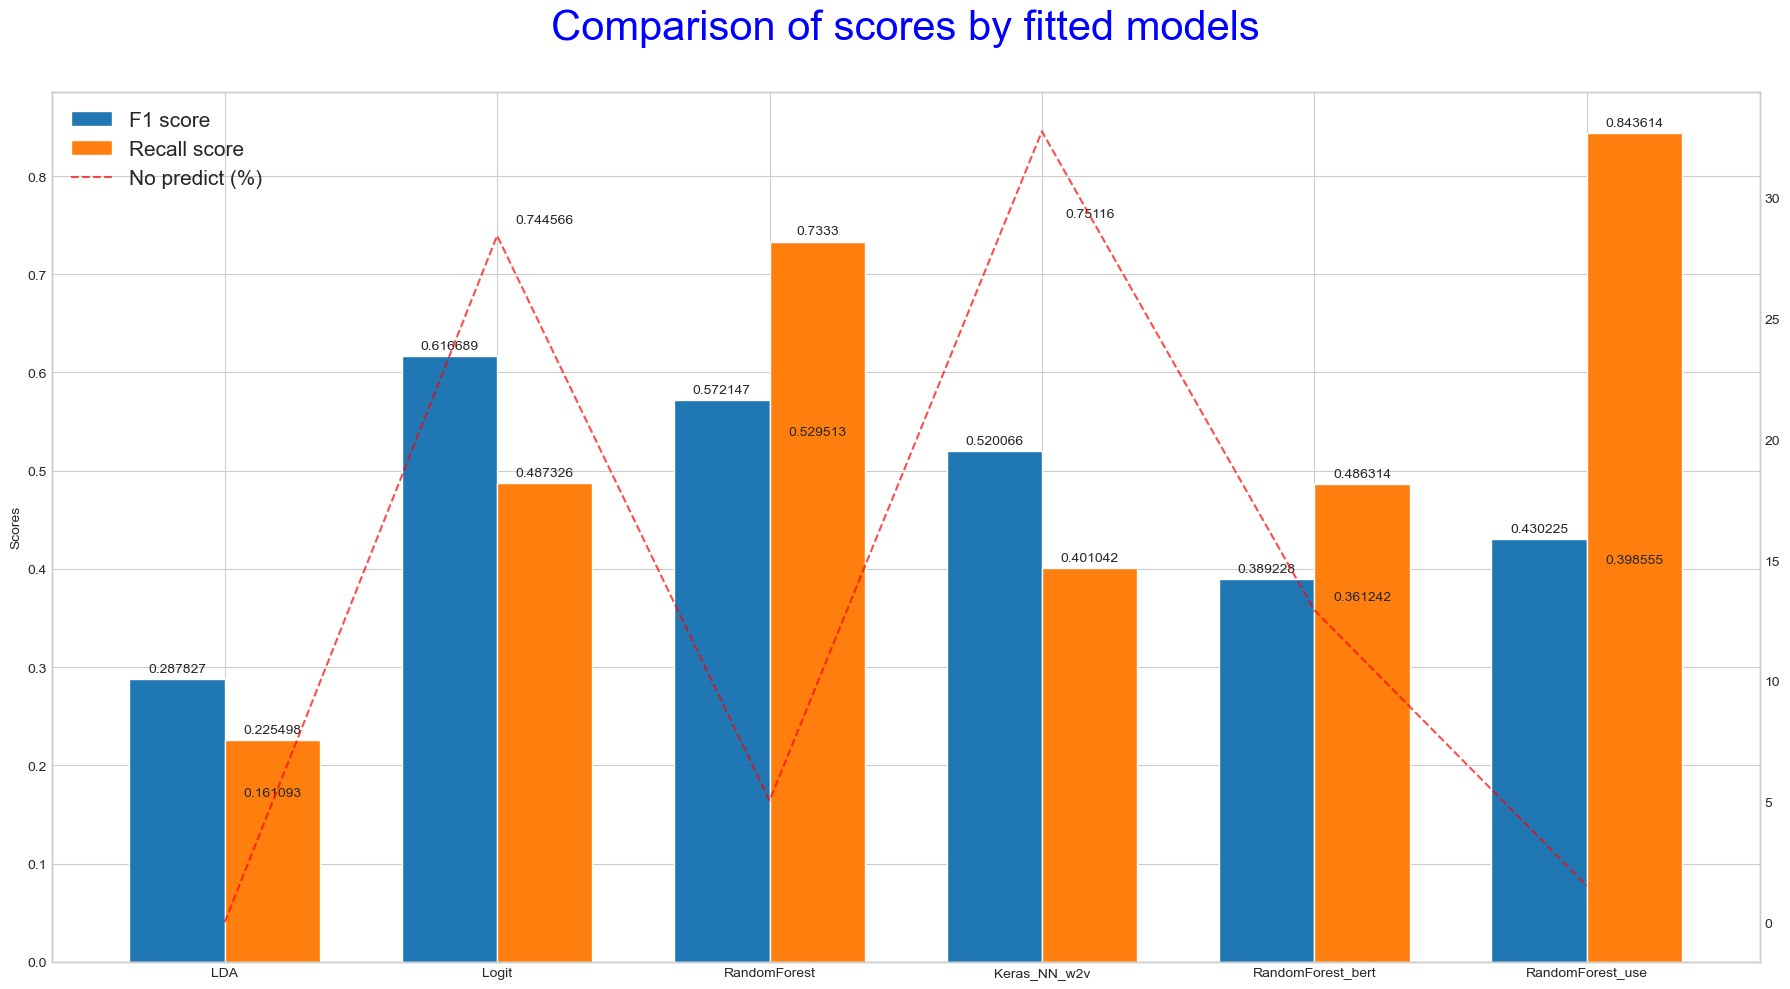

In [140]:
x = np.arange(len(df_metrics_rfc.columns))
width = 0.35

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111)
f1_scores = ax1.bar(x - width/2, df_metrics_rfc.iloc[1,:], width, label="F1 score")
recall_scores = ax1.bar(x + width/2, df_metrics_rfc.iloc[2,:], width, label="Recall score")
#prec_scores = ax1.bar(x + width/2, df_metrics_rfc.iloc[3,:], width, label="Precision score")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, [0,28.44,5.04,32.76,12.93,1.51],
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="blue", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics_rfc.columns)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,
           fontsize=15)

ax1.bar_label(f1_scores, padding=3)
ax1.bar_label(recall_scores, padding=3)
ax1.bar_label(prec_scores, padding=3)

fig.tight_layout()

plt.show()

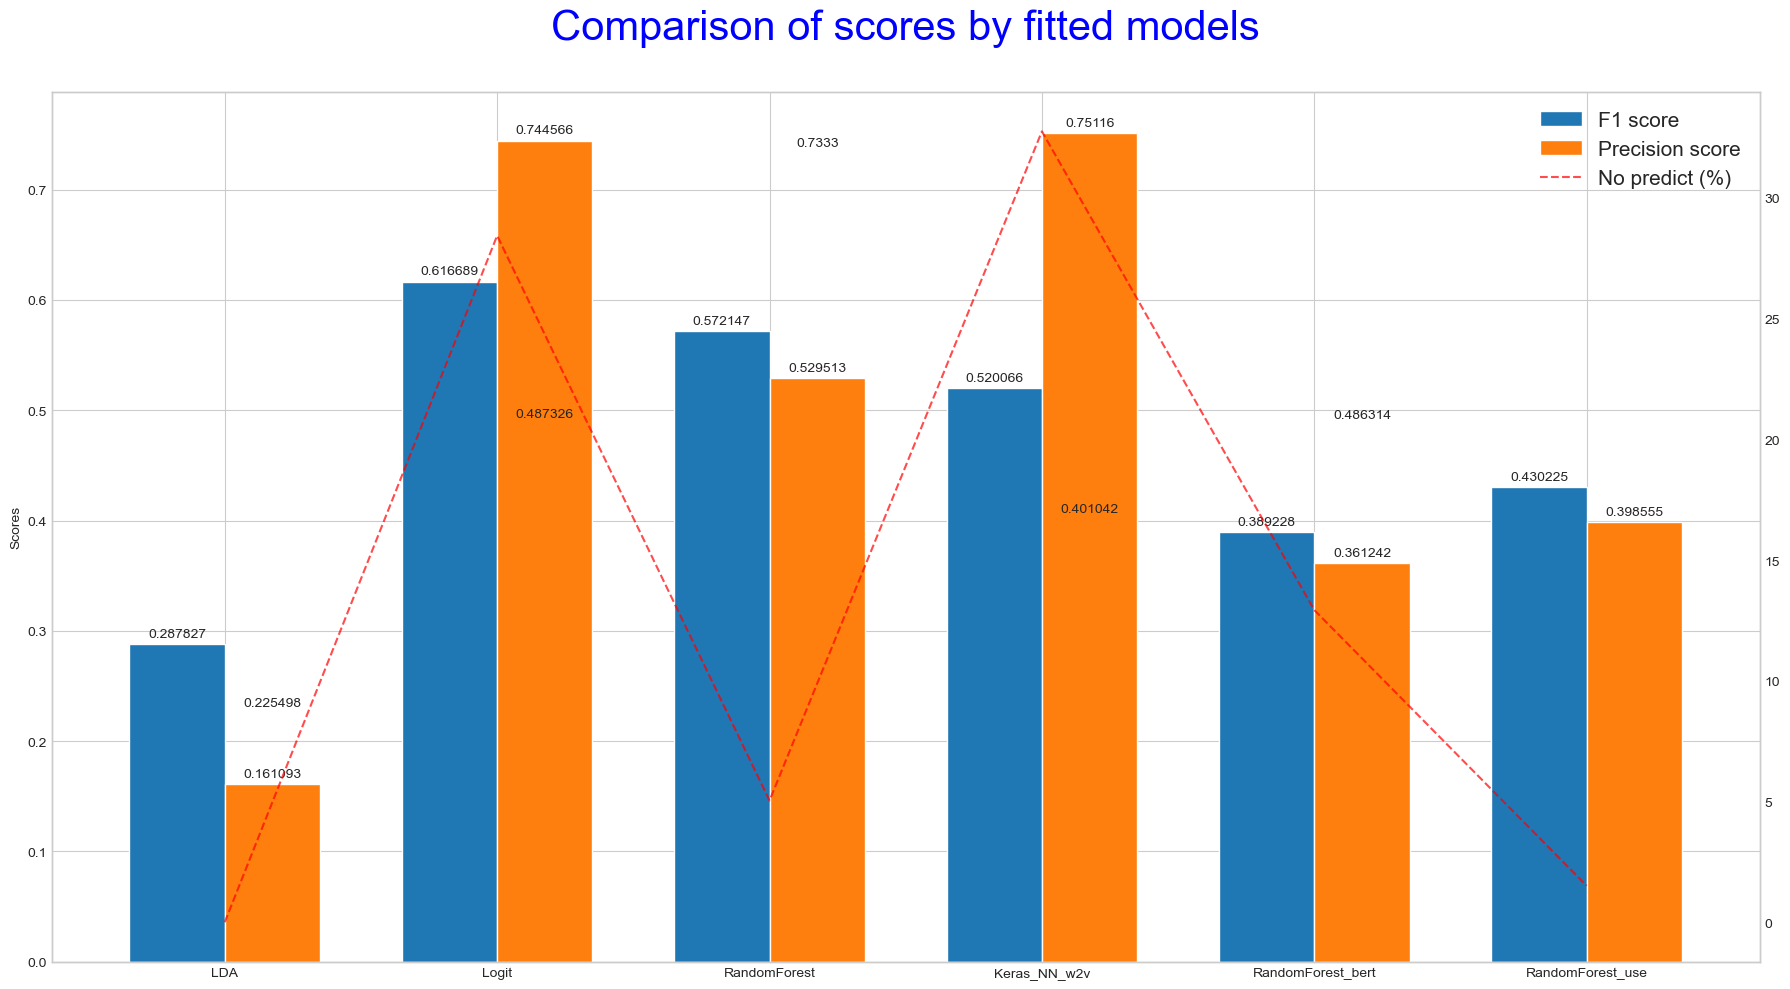

In [139]:
x = np.arange(len(df_metrics_rfc.columns))
width = 0.35

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111)
f1_scores = ax1.bar(x - width/2, df_metrics_rfc.iloc[1,:], width, label="F1 score")
#recall_scores = ax1.bar(x + width/2, df_metrics_rfc.iloc[2,:], width, label="Recall score")
prec_scores = ax1.bar(x + width/2, df_metrics_rfc.iloc[3,:], width, label="Precision score")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, [0,28.44,5.04,32.76,12.93,1.51],
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="blue", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(df_metrics_rfc.columns)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,
           fontsize=15)

ax1.bar_label(f1_scores, padding=3)
ax1.bar_label(recall_scores, padding=3)
ax1.bar_label(prec_scores, padding=3)

fig.tight_layout()

plt.show()

## Model save 

In [142]:
# Export fitted model and Preprocessor
import joblib
joblib.dump(multi_logit_cv,'logit_model.pkl')
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')
joblib.dump(multilabel_binarizer,'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']